In [1]:
import numpy as np
import pandas as pd

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
train_data = pd.read_csv('input/train.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
n_train = len(train_data)
n_pixels = len(train_data.columns) - 1
n_class = len(set(train_data['label']))

In [7]:
print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [8]:
test_data = pd.read_csv('input/test.csv')

n_test = len(test_data)
n_pixels = len(test_data.columns)

In [9]:
print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


C:\Users\usr\Anaconda3\envs\Py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


5, 3, 3, 7, 8, 5, 8, 7


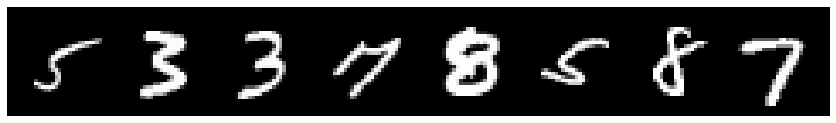

In [10]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_data.iloc[random_sel, 1:].as_matrix()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_data.iloc[random_sel, 0].values), sep = ', ')

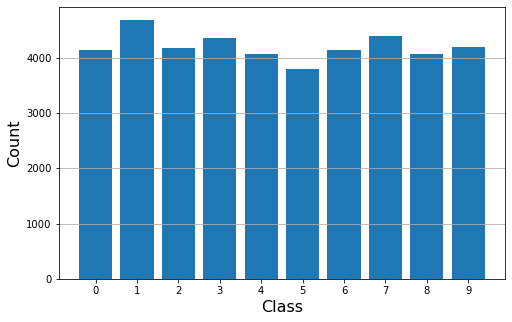

In [11]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_data['label'].value_counts().index, train_data['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

In [12]:
num, px = np.array(train_data).shape
height = width = int(np.sqrt(px-1))
num, px, height, width

(42000, 785, 28, 28)

In [13]:
img_min = np.array(train_data).min()
img_max = np.array(train_data).max()
img_min, img_max

(0, 255)

In [14]:
img_norm_mean = np.array(train_data, dtype=float).mean() / img_max
img_norm_mean

0.13087070313475707

In [15]:
img_std = np.sqrt(np.sum((np.array(train_data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
img_std

0.3085670315794816

In [16]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(img_norm_mean,), std=(img_std,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [17]:
train_dataset = MNIST_data('input/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                             transforms.ToTensor(), 
                             transforms.Normalize(mean=(img_norm_mean,), std=(img_std,))]))

test_dataset = MNIST_data('input/test.csv')


In [18]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                          shuffle=False)


In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=3, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, 
                               out_channels=5, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(5 * 22 * 22, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 5 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

In [20]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2420, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
torch.manual_seed(123)

In [23]:
epochs = 10
log_interval = 1000
iterations = len(train_loader.dataset)//batch_size

In [24]:
print("training set size                ", len(train_loader.dataset))
print("validation set size              ", len(test_loader.dataset))
print("batch size (training/validation) ", batch_size)
print("iterations in epoch              ", iterations)

training set size                 42000
validation set size               28000
batch size (training/validation)  8
iterations in epoch               5250


In [25]:
%%time

for epoch in range(epochs): # entire dataset is passed forward and backward through the nn
    model.train()
    
    epoch_training_loss = 0
    print("=== epoch %2d ===" % (epoch + 1))
    
    for batch_idx, training_batch in enumerate(train_loader, 0):        
        inputs, labels = training_batch[0].to(device), training_batch[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        
        #backward propagation
        loss.backward()
        
        # Update the parameters(weight,bias)
        optimizer.step()
        
        epoch_training_loss += loss.item()# .data
        if batch_idx % 1000 == 999:    
            print('Epoch %d, step %5d loss: %.3f' %
                  (epoch + 1, batch_idx + 1, epoch_training_loss / 1000))
            epoch_training_loss = 0.0


=== epoch  1 ===
Epoch 1, step  1000 loss: 1.632
Epoch 1, step  2000 loss: 0.450
Epoch 1, step  3000 loss: 0.359
Epoch 1, step  4000 loss: 0.308
Epoch 1, step  5000 loss: 0.287
=== epoch  2 ===
Epoch 2, step  1000 loss: 0.234
Epoch 2, step  2000 loss: 0.228
Epoch 2, step  3000 loss: 0.207
Epoch 2, step  4000 loss: 0.191
Epoch 2, step  5000 loss: 0.185
=== epoch  3 ===
Epoch 3, step  1000 loss: 0.165
Epoch 3, step  2000 loss: 0.169
Epoch 3, step  3000 loss: 0.148
Epoch 3, step  4000 loss: 0.152
Epoch 3, step  5000 loss: 0.135
=== epoch  4 ===
Epoch 4, step  1000 loss: 0.128
Epoch 4, step  2000 loss: 0.129
Epoch 4, step  3000 loss: 0.123
Epoch 4, step  4000 loss: 0.119
Epoch 4, step  5000 loss: 0.123
=== epoch  5 ===
Epoch 5, step  1000 loss: 0.108
Epoch 5, step  2000 loss: 0.097
Epoch 5, step  3000 loss: 0.106
Epoch 5, step  4000 loss: 0.109
Epoch 5, step  5000 loss: 0.102
=== epoch  6 ===
Epoch 6, step  1000 loss: 0.091
Epoch 6, step  2000 loss: 0.088
Epoch 6, step  3000 loss: 0.088
Ep

In [26]:
model.eval()
test_pred = torch.LongTensor()
test_pred = test_pred.to(device)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)

In [27]:
test_pred

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]], device='cuda:0')

In [29]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.cpu().numpy()], 
                      columns=['ImageId', 'Label'])

In [30]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [31]:
out_df.to_csv('submission_CNN3.csv', index=False)